This aims to predicti per district and not per tile.

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [11]:
# Load your CSV
df = pd.read_csv("/home/elsherif/Desktop/Thesis/ViewPython/data/CleanupDataSet/final_model.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12479 entries, 0 to 12478
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tile                         12479 non-null  object 
 1   total_rooftops               12479 non-null  int64  
 2   rooftops_without_solar       12479 non-null  int64  
 3   square_meters_with_solar_m2  12479 non-null  float64
 4   panel_area_m2                12479 non-null  float64
 5   district_number              12479 non-null  int64  
 6   year                         12479 non-null  int64  
 7   Unemployment_Rate            12479 non-null  float64
 8   Average_Age                  12479 non-null  float64
 9   Elderly_Population           12479 non-null  float64
 10  Young_Population             12479 non-null  float64
 11  Total_Population             12479 non-null  int64  
 12  employed                     12479 non-null  float64
 13  tile_encoded    

In [12]:
district_df = (
    df
    .groupby(["district_number", "year"], as_index=False)
    .agg({
        # SUM features
        "total_rooftops": "sum",
        "rooftops_without_solar": "sum",
        "square_meters_with_solar_m2": "sum",
        "panel_area_m2": "sum",
        "panel_area_lag1": "sum",


        # MEAN features
        "Total_Population": "sum",
        "Elderly_Population": "sum",
        "Young_Population": "sum",
        "Unemployment_Rate": "mean",
        "Average_Age": "mean",
        "employed" : "mean",
        "pv_price" : "mean"
    })
)


In [13]:
district_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   district_number              184 non-null    int64  
 1   year                         184 non-null    int64  
 2   total_rooftops               184 non-null    int64  
 3   rooftops_without_solar       184 non-null    int64  
 4   square_meters_with_solar_m2  184 non-null    float64
 5   panel_area_m2                184 non-null    float64
 6   panel_area_lag1              184 non-null    float64
 7   Total_Population             184 non-null    int64  
 8   Elderly_Population           184 non-null    float64
 9   Young_Population             184 non-null    float64
 10  Unemployment_Rate            184 non-null    float64
 11  Average_Age                  184 non-null    float64
 12  employed                     184 non-null    float64
 13  pv_price            

In [14]:
district_df.head(10)

,district_number,year,total_rooftops,rooftops_without_solar,square_meters_with_solar_m2,panel_area_m2,panel_area_lag1,Total_Population,Elderly_Population,Young_Population,Unemployment_Rate,Average_Age,employed,pv_price
0,1,2006,589,451,515994.250,10816.335,12163.415,490776,82004.0,47918.0,3.7,42.6,74.9,5440.0
1,1,2009,610,420,763786.758,24625.206,10816.335,492232,85410.0,50076.0,2.8,42.5,74.0,3800.0
2,1,2012,578,413,650589.294,14190.911,24625.206,521248,86658.0,56134.0,2.1,41.9,74.0,2150.0
3,1,2015,641,491,694887.747,15818.207,14190.911,549172,90740.0,60372.0,2.3,41.8,74.0,1550.0
4,1,2018,564,422,628974.357,10977.157,15818.207,548600,89232.0,63726.0,2.1,41.7,73.4,1350.0
5,1,2020,597,464,524832.486,11371.195,10977.157,544960,88608.0,65624.0,2.7,41.8,73.3,1280.0
6,1,2022,621,463,632525.779,13036.365,11371.195,541008,86840.0,65702.0,2.1,41.6,73.5,1550.0
7,1,2024,600,454,582289.704,11441.817,13036.365,542776,86996.0,64142.0,3.0,41.7,73.8,1350.0
8,2,2006,1118,951,570845.772,8196.166,11178.208,1829440,213160.0,184600.0,5.4,39.6,79.3,5440.0
9,2,2009,1082,821,899446.262,21414.943,8196.166,1857840,211240.0,193360.0,4.1,39.2,79.5,3800.0


In [15]:
district_df['panel_area_log'] = np.log1p(district_df['panel_area_m2'])


In [16]:
district_df

,district_number,year,total_rooftops,rooftops_without_solar,square_meters_with_solar_m2,panel_area_m2,panel_area_lag1,Total_Population,Elderly_Population,Young_Population,Unemployment_Rate,Average_Age,employed,pv_price,panel_area_log
0,1,2006,589,451,515994.250,10816.335,12163.415,490776,82004.0,47918.0,3.7,42.6,74.9,5440.0,9.288905
1,1,2009,610,420,763786.758,24625.206,10816.335,492232,85410.0,50076.0,2.8,42.5,74.0,3800.0,10.111566
2,1,2012,578,413,650589.294,14190.911,24625.206,521248,86658.0,56134.0,2.1,41.9,74.0,2150.0,9.560427
3,1,2015,641,491,694887.747,15818.207,14190.911,549172,90740.0,60372.0,2.3,41.8,74.0,1550.0,9.668980
4,1,2018,564,422,628974.357,10977.157,15818.207,548600,89232.0,63726.0,2.1,41.7,73.4,1350.0,9.303663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,25,2015,3110,2845,292754.389,15464.212,19301.390,2547204,493120.0,312616.0,3.8,42.5,70.2,1550.0,9.646348
180,25,2018,3143,2857,303005.510,18630.374,15836.149,2714208,510192.0,346608.0,3.1,42.2,70.1,1350.0,9.832602
181,25,2020,3343,3081,252987.421,16649.054,18630.374,2722992,510240.0,359280.0,4.2,42.3,70.1,1280.0,9.720169
182,25,2022,3254,2920,310594.541,21874.124,16649.054,2729040,496320.0,361872.0,3.7,42.2,70.3,1550.0,9.993105


In [17]:
feature_cols = [
    'total_rooftops',
    # 'rooftops_without_solar',
    # 'square_meters_with_solar_m2',
    'Unemployment_Rate',
    'Average_Age',
    'Elderly_Population',
    'Young_Population',
    'Total_Population',
    "employed",
    # 'tile_encoded',
    'panel_area_lag1',
            "employed",
        "pv_price",
        'year'
]

# Drop rows with missing lag values
df_model = district_df.dropna(subset=feature_cols + ['panel_area_log'])

X = df_model[feature_cols]
y = df_model['panel_area_log']


In [18]:
# Sort by time (CRITICAL)
df_model = df_model.sort_values("year")

# Define years
test_year = df_model["year"].max()
val_year  = df_model[df_model["year"] < test_year]["year"].max()

# Split dataframe
train_df = df_model[df_model["year"] < val_year]
val_df   = df_model[df_model["year"] == val_year]
test_df  = df_model[df_model["year"] == test_year]

# Features and target
X_train = train_df[feature_cols]
y_train = train_df["panel_area_log"]

X_val   = val_df[feature_cols]
y_val   = val_df["panel_area_log"]

X_test  = test_df[feature_cols]
y_test  = test_df["panel_area_log"]


Original features: 11
PCA components: 5
Explained variance ratio: [0.44430166 0.24725249 0.1823182  0.05519013 0.03267514]
Total variance explained: 0.9617


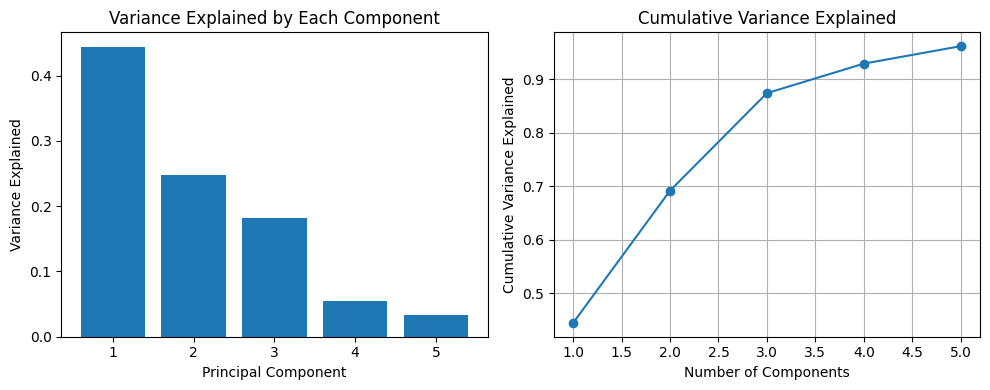

In [19]:
# Standardize features (required for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95, random_state=42)  # retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained')
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

# Train on PCA-transformed features
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_pca, y_train)

# Predict on PCA-transformed test set
y_pred = model.predict(X_test_pca)

# R2 score
print("R2 score:", r2_score(y_test, y_pred))

# RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)



R2 score: 0.7912242774680893
RMSE: 0.40277301145771865


In [21]:
y_pred_log = model.predict(X_test_pca)
y_pred = np.expm1(y_pred_log)          # inverse of log1p
y_test_real = np.expm1(y_test.values)  # convert back to original scale


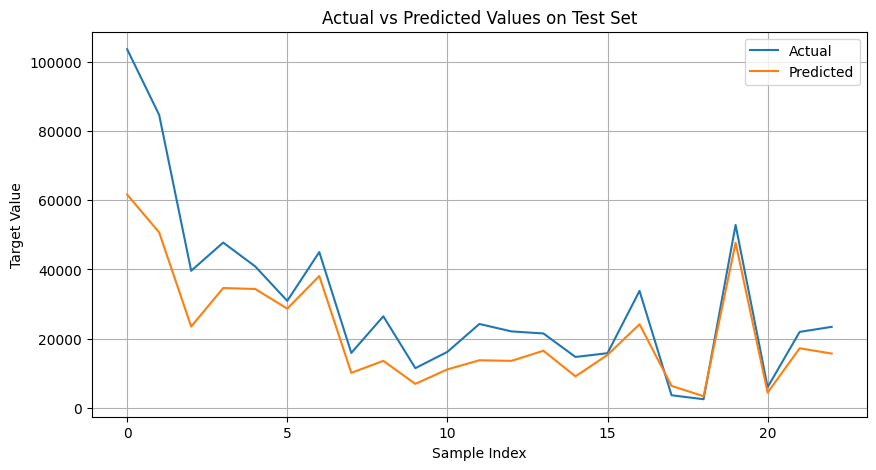

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_real, label="Actual")   # Add markers to see points clearly
plt.plot(y_pred, label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.title("Actual vs Predicted Values on Test Set")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
y_pred

array([61682.35251223, 50732.57641537, 23484.67919756, 34630.25077031,
       34354.69190866, 28668.84692226, 38105.04991318, 10082.00261501,
       13565.58456139,  6895.70975241, 11089.13519899, 13729.27504966,
       13555.07820096, 16483.6663543 ,  9078.46611007, 15278.42351017,
       24142.55422453,  6317.42378892,  3327.16905653, 47722.55936156,
        4367.21723332, 17198.71646053, 15673.48590038])

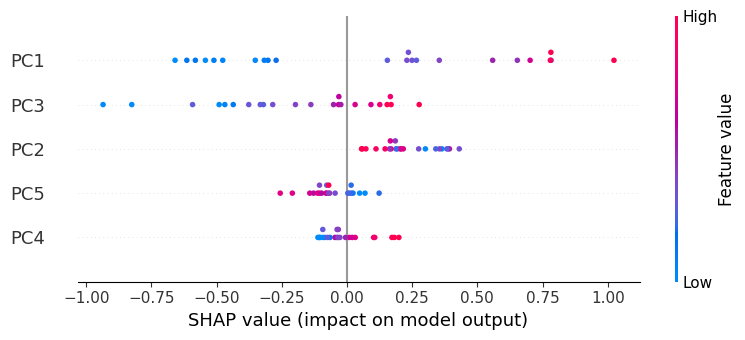

In [24]:
import shap

explainer = shap.TreeExplainer(model)

# Use PCA-transformed validation set
pca_feature_names = [f"PC{i+1}" for i in range(X_val_pca.shape[1])]
X_shap = pd.DataFrame(X_val_pca, columns=pca_feature_names)

shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap)

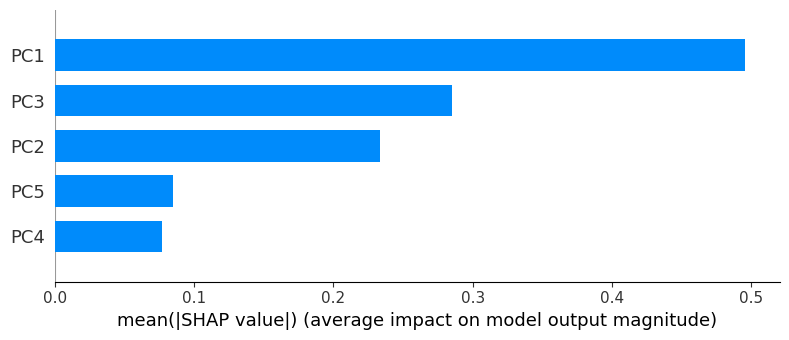

In [25]:
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar"
)
